# One shot learning with Omniglot Dataset

We are going to do one shot learning with Omniglot dataset. Omniglot dataset contains 1623 handwritten characters from 50 different alphabets, and there are 20 examples for each alphabet.

To download the dataset, visit the following link.
- https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip
- https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

Download the dataset and place the images_background folder and images_evaluation folder in the directory named 'data'

In [1]:
##import all the neccesary modules
import sys
import numpy as np
from scipy.misc import imread
import os
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

## Set logging dir for Tensorboard
logging_dir_n = 0

## The directory where data path is present
data_path = "data/"
train_path = os.path.join(data_path,'images_background')
validation_path = os.path.join(data_path,'images_evaluation')

def load_images_from_directory(path,n=0):
    X=[]
    
    ## We load every alphabet seperately and append that to one tensor
    for alphabet in os.listdir(path):
        if not alphabet.startswith('.'):
            print("loading alphabet: " + alphabet)
            alphabet_path = os.path.join(path,alphabet)

            ## Each character in alphabet is in a separate folder
            for letter in os.listdir(alphabet_path):
                if not letter.startswith('.'):
                    category_images=[]
                    letter_path = os.path.join(alphabet_path, letter)

                    if not os.path.isdir(letter_path):
                        continue

                    ## Read every image in this directory
                    for filename in os.listdir(letter_path):
                        if not filename.startswith('.'):
                            image_path = os.path.join(letter_path, filename)
                            image = imread(image_path)

                            ### Image preprocessing!
                            image = image/255
                            image = 1-image

                            category_images.append(image)

                    try:
                        X.append(np.stack(category_images))
                    #edge case  - last one
                    except ValueError as e:
                        print(e)
                        print("error - category_images:", category_images)
    
    X = np.stack(X)
    return X

print("Loading training set")
Xtrain = load_images_from_directory(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_images_from_directory(validation_path)
print(Xval.shape)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading training set
loading alphabet: Cyrillic


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Syriac_(Estrangelo)
loading alphabet: Gujarati
loading alphabet: Latin
loading alphabet: Burmese_(Myanmar)
loading alphabet: Japanese_(katakana)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Grantha
loading alphabet: Braille
loading alphabet: Early_Aramaic
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Arcadian
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Greek
loading alphabet: Japanese_(hiragana)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Bengali
loading alphabet: Armenian
loading alphabet: Tagalog
loading alphabet: Korean
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Sanskrit
loading alphabet: Balinese
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Hebrew
(964, 20, 105, 105)
Now loadin

Now we would like to have a neural network that can determine if two characters are similar or not. To do this we need a function that generates our input data while training, and a function that creates a dataset at evaluation.

The training data function we make will create the following:

- Two lists with images
- A list with number 1 if they belong to the same character, and the number 0 if they belong to different character.

The task function we will create gives us a list with N images, where only the first image is from the same alphabet.

In [2]:
def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise data we return in memory
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    ## Make a target vector with half same and half other categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the categories of characters we will return
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        ## Choose two indixes from the amount of examples we have
        idx_1 = rng.randint(0, n_examples)
        idx_2 = rng.randint(0, n_examples)
        
        if targets[i] == 0: 
            category_2 = category # if target is set: pick from same category
        else:
            ## Pick new class by picking random number 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[0][i,:,:,:] = data[category,idx_1].reshape(w,h,1)
        pairs[1][i,:,:,:] = data[category_2,idx_2].reshape(w,h,1)
  
    return pairs, targets

def make_oneshot_task(data, N):
    n_val, n_ex_val, w, h = data.shape

    categories = rng.choice(n_val,size=(N,),replace=False)
    true_category = categories[0]
    
    indices = rng.randint(0, n_ex_val,size=(N,))
    
    ex1, ex2 = rng.choice(n_ex_val,replace=False,size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    
    support_set = data[categories,indices,:,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0,:,:] = data[true_category,ex2] # Fill in this caracter
    
    
    ## Reshape the data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image,support_set]
    return pairs, targets

## Visualizing the Characters

Now that we have our utility functions defined, lets get a batch of train data and visualize them.

2


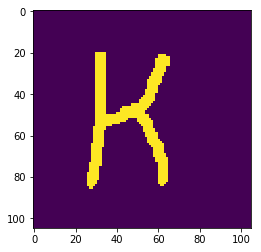

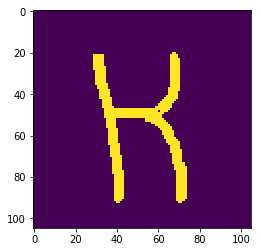

similarity/distance: 0.0


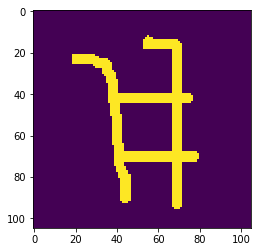

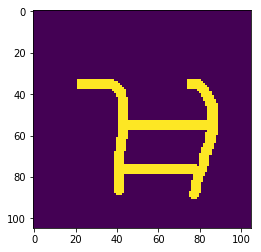

similarity/distance: 0.0


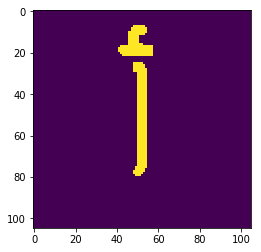

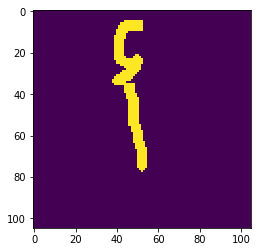

similarity/distance: 0.0


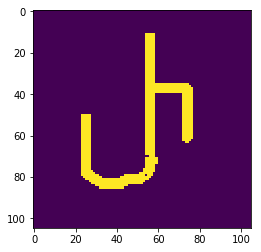

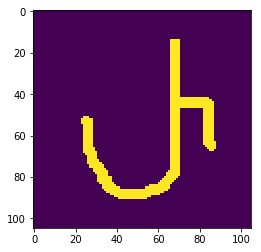

similarity/distance: 0.0


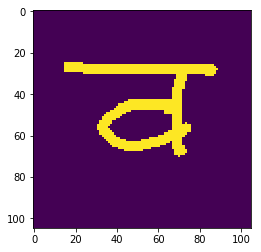

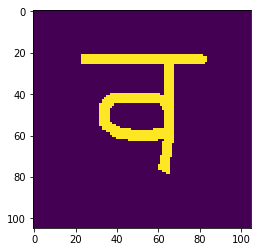

similarity/distance: 0.0


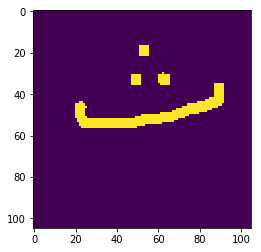

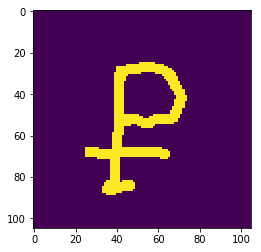

similarity/distance: 1.0


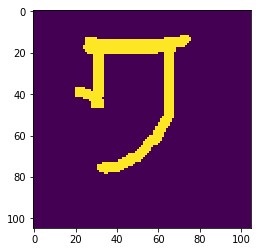

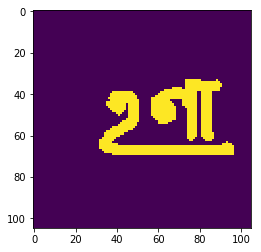

similarity/distance: 1.0


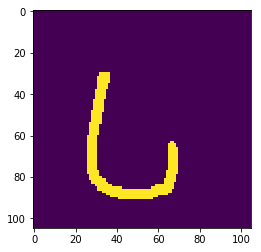

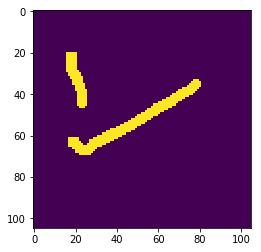

similarity/distance: 1.0


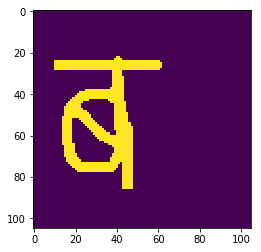

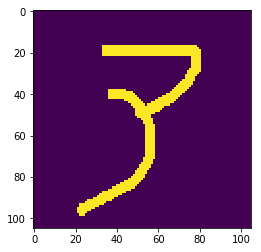

similarity/distance: 1.0


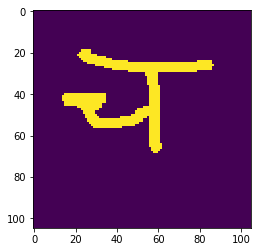

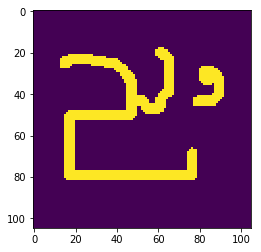

similarity/distance: 1.0


In [3]:
pairs, targets = get_batch(Xtrain, 10)
print(len(pairs))
for i in range(len(pairs[0])):
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    print("similarity/distance: " + str(targets[i]))

## Siamese Neural Networks

To perform one shot learning, we will make use of special kind of neural networks called siamese neural networks. We provide the siamese neural network two images of same class and ask the network whether its the same character or not. We perform this task by making a neural network generate same output encodings for the same images.The idea is that this neural network maps the same charater to the same output vector every time. 

![siamese](illustrations/siamesenetwork.png)

In [4]:
def get_siamese_input_network(x_input, reuse):
    tf.summary.image('image_in'+str(reuse), x_input)
    
    with tf.variable_scope("shared_weights", reuse=reuse):
        conv1 = tf.layers.conv2d(x_input, 8, [10, 10], name='conv1', activation=tf.nn.relu)
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
        conv2 = tf.layers.conv2d(maxp1, 16, [7, 7], name='conv2', activation=tf.nn.relu)
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
        conv3 = tf.layers.conv2d(maxp2, 16, [4, 4], name='conv3', activation=tf.nn.relu)
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

        conv4 = tf.layers.conv2d(maxp3, 32, [4, 4], name='conv4', activation=tf.nn.relu)
        flattened = tf.contrib.layers.flatten(conv4)
        
        dense1 = tf.layers.dense(flattened, 512, activation=tf.nn.sigmoid, name="dense1")          
    return dense1


In [5]:
tf.reset_default_graph()

image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image1")
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image2")
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1], name="labels")

## Process both images, note that the second network re-uses the weights of the first network
out_1 = get_siamese_input_network(image1, None)
out_2 = get_siamese_input_network(image2, True)

print([x.name for x in tf.global_variables()])

writer = tf.summary.FileWriter(logdir='graphs/siamese_start', graph=tf.get_default_graph())

['shared_weights/conv1/kernel:0', 'shared_weights/conv1/bias:0', 'shared_weights/conv2/kernel:0', 'shared_weights/conv2/bias:0', 'shared_weights/conv3/kernel:0', 'shared_weights/conv3/bias:0', 'shared_weights/conv4/kernel:0', 'shared_weights/conv4/bias:0', 'shared_weights/dense1/kernel:0', 'shared_weights/dense1/bias:0']


### Combining outputs by this network, and determining the loss
After we determined the output of our shared network part we have to see how well they match. To do this we can take the so-called "L1-distance", which is simply the absolute of output 1 minus output 2. Of course not every difference we get here has the same importance when determining if two images are the same. This is why we add a last dense layer that will indicate if two vectors are equal or not...

In [6]:
l_one = tf.abs(tf.subtract(out_1,out_2))
prediction = tf.layers.dense(l_one, 1, activation=tf.nn.sigmoid, name="output")
mseloss = tf.losses.mean_squared_error(label_placeholder,prediction)

optimizer = tf.train.AdamOptimizer().minimize(mseloss)

training_summary = tf.summary.scalar('mseloss', mseloss)
merged = tf.summary.merge_all()

## Training the network

In [7]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [8]:
BATCH_SIZE = 64

for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], 
                          feed_dict={image1: pairs[0], 
                                     image2: pairs[1], 
                                     label_placeholder: targets })
    writer.add_summary(summary, iteration)

### Evaluating your network

We evaluate our network by building a very simple task: we take one character, and show that character next to N random characters and 1 of the same character (but a different drawing). We then compare the output of the neural network. If the network performs well it gives the lowest difference score to the same character as the baseline. 

We can choose how difficult we make this task by changing the amount of choices we give to our network. From the challenge, we give it 20 choices. 

By performing this task multiple times we determine the accuracy of our network. 

To implement the evaluation we use the `make_oneshot_task` defined earlier. This function has two of the similar character as first index. If the lowest score is on the first place the network got it correct!

In [9]:
CHOOSE_FROM_N = 20
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, 
                    feed_dict={image1: inputs[0], 
                               image2: inputs[1]})
    maxindex = np.argmin(pred)

    if maxindex == 0:
        correct_tested += 1
        
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

Accuracy in best of 20
0.4266666666666667


## Alternative loss functions

One of the loss functions suitable for one shot learning and siamese networks is Contrasive loss function. The first loss function takes the L1 distance, and then train a classifier to determine what features in this vector are important to determine the distance. The Contrasive loss function learns the parameters in such a way that the similar characters are pulled together and the dissimilar characters are pushed apart by a margin of some value.

In [14]:
def contrastive_loss(char1, char2, labels, margin):
    y = tf.reshape(labels, [-1])
    with tf.name_scope("contrastive-loss"):
        l_two = tf.square(char1-char2)
        distance = tf.reduce_sum(l_two, axis=1)
        
        negativepart = (1-y)*distance
        positivepart = y*tf.maximum(0.0,margin-distance)
        
        contrastiveloss = negativepart + positivepart
        contrastiveloss = tf.reduce_mean(contrastiveloss)
    return contrastiveloss, distance


margin=1
contrastiveloss, distance = contrastive_loss(out_1, out_2, label_placeholder, margin)
contr_loss_summary = tf.summary.scalar('contrastiveloss', contrastiveloss)
merged = tf.summary.merge_all()


optimizer = tf.train.AdamOptimizer().minimize(contrastiveloss)

In [15]:
## Initialize the summarywriter and session again
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [16]:
BATCH_SIZE = 64

for iteration in range(10000):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

## Determining Accuracy

In [17]:
CHOOSE_FROM_N = 20
TEST_COUNT = 200
correct_tested = 0

for _ in range(TEST_COUNT):
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    dist = sess.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
    maxindex = np.argmin(dist)

    if maxindex == 0:
        correct_tested += 1
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

Accuracy in best of 20
0.775


There are many hyperparameters that influences the neural network accuracy. Batch size, margin of the contrasive loss, the size of dense layers, the size of conv layers, how deep the conv layers are and many other factors. For now, I could achieve an accuracy of 0.54.